In [4]:
%load_ext autoreload
%autoreload 2

In [294]:
# Imports
import numpy as np
from typing import List, Tuple, Union
from numpy.typing import ArrayLike
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib.plt'

In [390]:
class NeuralNetwork:
    """
    This is a class that generates a fully-connected neural network.

    Parameters:
        nn_arch: List[Dict[str, float]]
            A list of dictionaries describing the layers of the neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}]
            will generate a two-layer deep network with an input dimension of 64, a 32 dimension hidden layer, and an 8 dimensional output.
        lr: float
            Learning rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.

    Attributes:
        arch: list of dicts
            (see nn_arch above)
    """

    def __init__(
        self,
        #this throwing error fix later
        #nn_arch: List[Dict[str, Union(int, str)]],
        nn_arch: List, 
        lr: float,
        seed: int,
        batch_size: int,
        epochs: int,
        loss_function: str
    ):

        # Save architecture
        self.arch = nn_arch

        # Save hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size

        # Initialize the parameter dictionary for use in training
        self._param_dict = self._init_params()
        #print(self._param_dict)

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD! IT IS ALREADY COMPLETE!

        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.

        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """

        # Seed NumPy
        np.random.seed(self._seed)

        # Define parameter dictionary
        param_dict = {}

        # Initialize each layer's weight matrices (W) and bias matrices (b)
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1

        return param_dict

    def _single_forward(
        self,
        W_curr: ArrayLike,
        b_curr: ArrayLike,
        A_prev: ArrayLike,
        activation: str
    ) -> Tuple[ArrayLike, ArrayLike]:
        """
        This method is used for a single forward pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            activation: str
                Name of activation function for current layer.

        Returns:
            A_curr: ArrayLike
                Current layer activation matrix.
            Z_curr: ArrayLike
                Current layer linear transformed matrix.
        """
        
        #need to multiply every node in last layer with weights 
        #then apply activation function 
        
        
        #Z is before A
        Z_curr=np.dot(A_prev, W_curr.T) + b_curr.T
        
        #apply activation function 
        
        if activation =='sigmoid':
            A_curr=self._sigmoid(Z_curr)
        
        
        elif activation =='relu':
            A_curr=self._relu(Z_curr)
                    
        else:
            raise Exception('no suitable activation function chosen!!!!!!!1!!!!')
        
        
        
        return(A_curr, Z_curr)
    
    
    

    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        """
        This method is responsible for one forward pass of the entire neural network.

        Args:
            X: ArrayLike
                Input matrix with shape [batch_size, features].

        Returns:
            output: ArrayLike
                Output of forward pass.
            cache: Dict[str, ArrayLike]:
                Dictionary storing Z and A matrices from `_single_forward` for use in backprop.
        """
        
        
        cache={}
                
        #for the first layer 
        A_prev=X
        #add to cache
        cache['A0']=X

        
        #loop through remaining number of layers in nn
        for l in range(1,len(self.arch)+1):
            #print('layer',  l)
            

            #weights 
            W_curr=self._param_dict['W'+str(l)]
            b_curr=self._param_dict['b'+str(l)]
            
            activation=self.arch[l-1]['activation']
            
            #go through one step of feed forward 
            #remember that A is activation matrix, Z is linearly transformed matrix
            A_curr, Z_curr=self._single_forward(W_curr, b_curr, A_prev, activation)

            
            cache['A'+str(l)]=A_curr
            cache['Z'+str(l)]=Z_curr
            
            
            A_prev=A_curr
            
        output=A_curr
            
        return(output, cache)
            

    def _single_backprop(
        self,
        W_curr: ArrayLike,
        b_curr: ArrayLike,
        Z_curr: ArrayLike,
        A_prev: ArrayLike,
        dA_curr: ArrayLike,
        activation_curr: str
    ) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
        """
        This method is used for a single backprop pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            Z_curr: ArrayLike
                Current layer linear transform matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            dA_curr: ArrayLike
                Partial derivative of loss function with respect to current layer activation matrix.
            activation_curr: str
                Name of activation function of layer.

        Returns:
            dA_prev: ArrayLike
                Partial derivative of loss function with respect to previous layer activation matrix.
            dW_curr: ArrayLike
                Partial derivative of loss function with respect to current layer weight matrix.
            db_curr: ArrayLike
                Partial derivative of loss function with respect to current layer bias matrix.
        """
        
        if activation_curr=='sigmoid':
            dZ=self._sigmoid_backprop(dA_curr, Z_curr)
        
        elif activation_curr=='relu':
            dZ=self._relu_backprop(dA_curr, Z_curr)
        else:
            raise Exception('no suitable activation function chosen!! check ur spelling')
            
        #check this   
        m=A_prev.shape[1]
        dW_curr=np.dot(dZ.T, A_prev) / m 
        db_curr=np.sum(dZ, axis=0) / m 
        #dA_prev=np.dot(W_curr.T, dZ.T)
        dA_prev=(dZ, W_curr)
        
        
        return(dA_prev, dW_curr, db_curr)
        


    def backprop(self, y: ArrayLike, y_hat: ArrayLike, cache: Dict[str, ArrayLike]):
        """
        This method is responsible for the backprop of the whole fully connected neural network.

        Args:
            y (array-like):
                Ground truth labels.
            y_hat: ArrayLike
                Predicted output values.
            cache: Dict[str, ArrayLike]
                Dictionary containing the information about the
                most recent forward pass, specifically A and Z matrices.

        Returns:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from this pass of backprop.
        """
        
        
        
        
        grad_dict={}
        
        #go b a c k w a r d s 
        for l in range(len(self.arch), 0, -1):
           # print('backprop layer: ', l)
            
            
            #need to get all the variables to run backpropasdfkl
            #i think they come from cache, which comes from forward prop
            W_curr=self._param_dict['W' + str(l)]
            b_curr=self._param_dict['b' + str(l)]
            Z_curr=cache['Z' + str(l)]
            A_prev=cache['A' + str(l-1)]
            activation_curr=self.arch[l-1]['activation']
            
            
            #get dA i think
            #calculate loss 
            if self._loss_func =='mse':
                dA_curr=self._mean_squared_error_backprop(y=y, y_hat=y_hat)
            elif self._loss_func =='bce':
                dA_curr=self._binary_cross_entropy_backprop(y=y, y_hat=y_hat)
            else:
                raise Exception('No availalbe loss function chosen')
                 
            
            
            #idk man idk 
            dA_prev, dW_curr, db_curr=self._single_backprop(W_curr, b_curr, Z_curr,A_prev, dA_curr, activation_curr)
            
            #print("dW_curr shape", dW_curr.shape)
            #print("dA_prev shape", dA_prev.shape)
            #print("db_curr shape", db_curr.shape)
            
            
            #print("param W shape", self._param_dict['W'+str(l)].shape)
            #print("param b shape", self._param_dict['b'+str(l)].shape)
            
            
            #update grad_dict with gradients for W, b, A 
            grad_dict['W'+str(l)]=dW_curr
            grad_dict['b'+str(l)]=db_curr
            grad_dict['A'+str(l-1)]=dA_prev
            

            
        return(grad_dict)
            

    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        """
        This function updates the parameters in the neural network after backprop. This function
        only modifies internal attributes and does not return anything

        Args:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from most recent round of backprop.
        """
                    
            
        #go through each layer and get corresponding gradient for each node
        
        for l in range(1,len(self.arch)+1):
                        
            #get relevant B and W grad 
            #w_grad=grad_dict['W'+str(l)]
            #b_grad=grad_dict['b'+str(l)]
            
            #idk if the indices are right 
            #update based on learning rate and gradient for that node 
            self._param_dict['W'+str(l)] -= self._lr * grad_dict['W'+str(l)]
            self._param_dict['b'+str(l)] -= self._lr * np.expand_dims(grad_dict['b'+str(l)], 1)
            
            
            
            #i think just these two?

            
       
            
            
            
            
    

    def fit(
        self,
        X_train: ArrayLike,
        y_train: ArrayLike,
        X_val: ArrayLike,
        y_val: ArrayLike
    ) -> Tuple[List[float], List[float]]:
        """
        This function trains the neural network by backpropagation for the number of epochs defined at
        the initialization of this class instance.

        Args:
            X_train: ArrayLike
                Input features of training set.
            y_train: ArrayLike
                Labels for training set.
            X_val: ArrayLike
                Input features of validation set.
            y_val: ArrayLike
                Labels for validation set.

        Returns:
            per_epoch_loss_train: List[float]
                List of per epoch loss for training set.
            per_epoch_loss_val: List[float]
                List of per epoch loss for validation set.
        """
        
        
        #init lists to store losses 
        per_epoch_loss_train=[]
        per_epoch_loss_val=[]
        
            
        for epoch in range(self._epochs):
           
            
            if epoch % 50==0:
                 print('epoch: ', epoch)
            
            
            #this take nfrom hw7 
            # Shuffling the training data for each epoch of training
            #only need to expand dims if y_train has one dimension i think 
            #y_train=np.expand_dims(y_train, 1)
            #would also need to reflatten y_train after
            #.flatten()
            

            idx=np.arange(X_train.shape[0])
            np.random.shuffle(idx)
            X_train = X_train[idx, :]
            y_train = y_train[idx, :]
            
            
            #print('X_train shape', X_train.shape)
            #print('y_train shape', y_train.shape)
                      
        
            # Create batches
            num_batches = int(X_train.shape[0] / self._batch_size) + 1
            X_batch = np.array_split(X_train, num_batches)
            y_batch = np.array_split(y_train, num_batches)
                
            
            #store losses for each training batch 
            batch_loss_train=[]
            
            # Iterate through batches (one of these loops is one epoch of training)
            for X_train, y_train in zip(X_batch, y_batch):
                
                #print('X_train shape', X_train.shape)
                #print('y_train shape', y_train.shape)
                
                
                #forward pass
                y_pred, cache = self.forward(X_train)
                #print('y_pred shape', y_pred.shape)

                #calculate loss 
                if self._loss_func =='mse':
                    train_loss=self._mean_squared_error(y=y_train, y_hat=y_pred)
                elif self._loss_func =='bce':
                    train_loss=self._binary_cross_entropy(y=y_train, y_hat=y_pred)
                else:
                    raise Exception('No availalbe loss function chosen')
                  
                #add to batch loss list 
                batch_loss_train.append(train_loss)
                
                
                #then, backpropagate 
                grad_dict=self.backprop(y=y_train, y_hat=y_pred, cache=cache)
                

                    
                    
                #update parameter weights 
                self._update_params(grad_dict)
                
                #is that it?????????/?sdflkajdslkfjalskdflaksdjf
                
          

    
            #after running all train batches
        
            #get mean of batch losses and add to epoch loss
            per_epoch_loss_train.append(np.mean(batch_loss_train))
            
            
            #Then, validation
            #Make one prediction on val for each epoch 
            #idk if this is how it should be 
            
            val_pred = self.predict(X_val)
            
            
            if self._loss_func =='mse':
                val_loss=self._mean_squared_error(y=y_val, y_hat=val_pred)          
            elif self._loss_func =='bce':
                val_loss=self._binary_cross_entropy(y=y_val, y_hat=val_pred)
            else:
                raise Exception('No availalbe loss function chosen')
                
                
            #add loss to per epoch loss val
            per_epoch_loss_val.append(val_loss)

            
        #return training and validation losses
        return(per_epoch_loss_train, per_epoch_loss_val)




    def predict(self, X: ArrayLike) -> ArrayLike: #DONE
        """
        This function returns the prediction of the neural network.

        Args:
            X: ArrayLike
                Input data for prediction.

        Returns:
            y_hat: ArrayLike
                Prediction from the model.
        """
        
        y_hat,_ =self.forward(X)
        return y_hat

    def _sigmoid(self, Z: ArrayLike) -> ArrayLike: #DONE
        """
        Sigmoid activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        return((1/(1+np.exp(-Z))))

    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike): #DONE
        """
        Sigmoid derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        
        sig_Z=self._sigmoid(Z)
        dZ=dA*sig_Z*(1-sig_Z)
        
        return(dZ)
    

    def _relu(self, Z: ArrayLike) -> ArrayLike: #DONE
        """
        ReLU activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        return(np.maximum(0, Z))
    

    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike: #DONE I THINK
        """
        ReLU derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        
        relu_Z=self._relu(Z)
        
        dZ=np.multiply(dA, relu_Z)
        
        return(dZ)
        
        

    def _binary_cross_entropy(self, y: ArrayLike, y_hat: ArrayLike, error=1e-5) -> float: #DONE
        """
        Binary cross entropy loss function.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            loss: float
                Average loss over mini-batch.
        """
        #add error so no divide by zero warning
        bce_loss= -np.mean(y*(np.log(y_hat + error)) +  (1-y)*np.log(1-y_hat + error)) 
        return(bce_loss)
    

    def _binary_cross_entropy_backprop(self, y: ArrayLike, y_hat: ArrayLike, error=-1e5) -> ArrayLike:
        """
        Binary cross entropy loss function derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        bce=self._binary_cross_entropy(y, y_hat)
        
        #i had to google this i'm sorry
        #add error for divide by zero 
        #need to double check this i think it's wrong 
        dA=np.mean(-(y/y_hat + error) + (1-y)/(1-y_hat+error))
        #dA=np.mean((y/y_hat + error) + (1-y)/(1-y_hat+error))

        
        return(dA)
     
        
    

    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Mean squared error loss.

        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.

        Returns:
            loss: float
                Average loss of mini-batch.
        """

        mse = np.mean((y - y_hat) ** 2)
        return(mse)

    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Mean square error loss derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        
        dA=np.mean(2*(y_hat-y))
        return(dA)

In [391]:
example_NN = NeuralNetwork(nn_arch = [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'}, 
                                      {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
                            lr = 0.01, seed = 3, batch_size = 50, epochs = 200, loss_function='mse')


#params are arrays of W1-Wx where x is feature number
#and also an array for b1 

In [392]:
#YOU FOOL
#BC IT'S AN AUTOENCODER INPUT AND OUTPUT SHOULD BE THE SAME GLAKSDJF'LAKSDFJ'
per_epoch_loss_train, per_epoch_loss_val=example_NN.fit(X_train, X_train, X_test, X_test)
#ah yes nothign works 

epoch:  0
epoch:  50
epoch:  100
epoch:  150


In [393]:
#digits.data is shape (1794, 64) --> 64 is flattened image pixels 
digits = load_digits()
  
#split into train and test sets 
X_train, X_test, y_train, y_test=train_test_split(digits.data, digits.target, train_size=0.2, random_state=3)
X_train.shape

(359, 64)

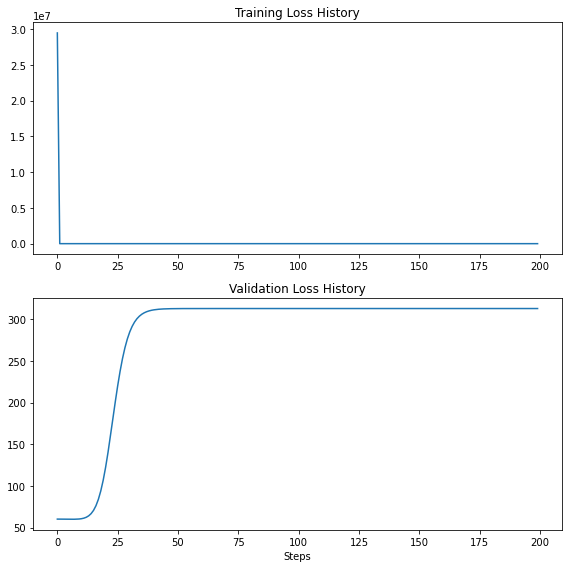

In [395]:
#taken from hw7
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2, figsize=(8, 8))
axs[0].plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
axs[0].set_title('Training Loss History')
axs[1].plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
axs[1].set_title('Validation Loss History')
plt.xlabel('Steps')
fig.tight_layout()
plt.show()

4
3
2
